# Paint By Example: Exemplar-based Image Editing with Diffusion Models




#### Table of contents:

- [Stable Diffusion in Diffusers library](#Stable-Diffusion-in-Diffusers-library)
- [Download default images](#Download-default-images)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
- [Prepare Inference pipeline](#Prepare-Inference-pipeline)
- [Select inference device](#Select-inference-device)
- [Configure Inference Pipeline](#Configure-Inference-Pipeline)
- [Quantization](#Quantization)
  - [Prepare Inference pipeline](#Prepare-Inference-pipeline)
  - [Run quantization](#Run-quantization)
  - [Run inference](#Run-inference)
  - [Compare UNet file size](#Compare-UNet-file-size)
- [Interactive inference](#Interactive-inference)



### Stable Diffusion in Diffusers library
[back to top ⬆️](#Table-of-contents:)
To work with Stable Diffusion, we will use the Hugging Face [Diffusers](https://github.com/huggingface/diffusers) library. To experiment with in-painting we can use Diffusers which exposes the [StableDiffusionInpaintPipeline](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). The code below demonstrates how to create `StableDiffusionInpaintPipeline` using `stable-diffusion-2-inpainting`.
To create the drawing tool we will install Gradio for handling user interaction.

This is the overall flow of the application:
![Flow Diagram](https://user-images.githubusercontent.com/103226580/236954918-f364b227-293c-4f78-a9bf-9dcebcb1034a.png)

This is the detailed flowchart for the pipeline:
![pipeline-flowchart](https://github.com/openvinotoolkit/openvino_notebooks/assets/103226580/cde2d5c4-2540-4a45-ad9c-339f7a69459d)

In [1]:
%pip install -q torch torchvision --extra-index-url "https://download.pytorch.org/whl/cpu"
%pip install -q "diffusers>=0.25.0" "peft<=0.6.2" "openvino>=2023.2.0" "transformers>=4.25.1" ipywidgets opencv_python pillow "nncf>=2.7.0" "gradio==3.44.1"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Download the model from [HuggingFace Paint-by-Example](https://huggingface.co/Fantasy-Studio/Paint-by-Example). This might take several minutes because it is over 5GB

In [2]:
from diffusers import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler


pipeline = DiffusionPipeline.from_pretrained("Fantasy-Studio/Paint-By-Example")

scheduler_inpaint = DDIMScheduler.from_config(pipeline.scheduler.config)

/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
image_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.


In [3]:
import gc

extractor = pipeline.feature_extractor
image_encoder = pipeline.image_encoder
image_encoder.eval()
unet_inpaint = pipeline.unet
unet_inpaint.eval()
vae_inpaint = pipeline.vae
vae_inpaint.eval()

del pipeline
gc.collect();

### Download default images
[back to top ⬆️](#Table-of-contents:)

Download default images.

In [4]:
# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file

download_file("https://github-production-user-asset-6210df.s3.amazonaws.com/103226580/286377210-edc98e97-0e43-4796-b771-dacd074c39ea.png", "0.png", "data/image")

download_file("https://github-production-user-asset-6210df.s3.amazonaws.com/103226580/286377233-b2c2d902-d379-415a-8183-5bdd37c52429.png", "1.png", "data/image")

download_file("https://github-production-user-asset-6210df.s3.amazonaws.com/103226580/286377248-da1db61e-3521-4cdb-85c8-1386d360ce22.png", "2.png", "data/image")

download_file("https://github-production-user-asset-6210df.s3.amazonaws.com/103226580/286377279-fa496f17-e850-4351-87c5-2552dfbc4633.jpg", "bird.jpg", "data/reference")

download_file("https://github-production-user-asset-6210df.s3.amazonaws.com/103226580/286377298-06a25ff2-84d8-4d46-95cd-8c25efa690d8.jpg", "car.jpg", "data/reference")

download_file("https://github-production-user-asset-6210df.s3.amazonaws.com/103226580/286377318-8841a801-1933-4523-a433-7d2fb64c47e6.jpg", "dog.jpg", "data/reference")


'data/image/0.png' already exists.
'data/image/1.png' already exists.
'data/image/2.png' already exists.
'data/reference/bird.jpg' already exists.
'data/reference/car.jpg' already exists.
'data/reference/dog.jpg' already exists.


PosixPath('/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/data/reference/dog.jpg')

### Convert models to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

Adapted from [236 Stable Diffusion v2 Infinite Zoom notebook](../236-stable-diffusion-v2/236-stable-diffusion-v2-infinite-zoom.ipynb)

In [5]:
from pathlib import Path
import torch
import numpy as np
import openvino as ov

model_dir = Path("model")
model_dir.mkdir(exist_ok=True)
sd2_inpainting_model_dir = Path("model/paint_by_example")
sd2_inpainting_model_dir.mkdir(exist_ok=True)

Functions to convert to OpenVINO IR format

In [6]:
def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def convert_image_encoder(image_encoder: torch.nn.Module, ir_path:Path):
    """
    Convert Image Encoder model to IR. 
    Function accepts pipeline, prepares example inputs for conversion
    Parameters: 
        image_encoder (torch.nn.Module): image encoder PyTorch model
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class ImageEncoderWrapper(torch.nn.Module):
        def __init__(self, image_encoder):
            super().__init__()
            self.image_encoder = image_encoder

        def forward(self, image):
            image_embeddings, negative_prompt_embeds = self.image_encoder(image, return_uncond_vector=True)
            return image_embeddings, negative_prompt_embeds

    if not ir_path.exists():
        image_encoder = ImageEncoderWrapper(image_encoder)
        image_encoder.eval()
        input_ids = torch.randn((1,3,224,224))
        # switch model to inference mode

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            ov_model = ov.convert_model(
                image_encoder,
                example_input=input_ids,
                input=([1,3,224,224],)
            )
            ov.save_model(ov_model, ir_path)
            del ov_model
            cleanup_torchscript_cache()
        print('Image Encoder successfully converted to IR')

        
def convert_unet(unet:torch.nn.Module, ir_path:Path, num_channels:int = 4, width:int = 64, height:int = 64):
    """
    Convert Unet model to IR format. 
    Function accepts pipeline, prepares example inputs for conversion 
    Parameters: 
        unet (torch.nn.Module): UNet PyTorch model
        ir_path (Path): File for storing model
        num_channels (int, optional, 4): number of input channels
        width (int, optional, 64): input width
        height (int, optional, 64): input height
    Returns:
        None
    """
    dtype_mapping = {
        torch.float32: ov.Type.f32,
        torch.float64: ov.Type.f64
    }
    if not ir_path.exists():
        # prepare inputs
        encoder_hidden_state = torch.ones((2, 1, 768))
        latents_shape = (2, num_channels, width, height)
        latents = torch.randn(latents_shape)
        t = torch.from_numpy(np.array(1, dtype=np.float32))
        unet.eval()
        dummy_inputs = (latents, t, encoder_hidden_state)
        input_info = []
        for input_tensor in dummy_inputs:
            shape = ov.PartialShape(tuple(input_tensor.shape))
            element_type = dtype_mapping[input_tensor.dtype]
            input_info.append((shape, element_type))

        with torch.no_grad():
            ov_model = ov.convert_model(
                unet, 
                example_input=dummy_inputs,
                input=input_info
            )
            ov.save_model(ov_model, ir_path)
            del ov_model
            cleanup_torchscript_cache()
        print('U-Net successfully converted to IR')


def convert_vae_encoder(vae: torch.nn.Module, ir_path: Path, width:int = 512, height:int = 512):
    """
    Convert VAE model to IR format. 
    Function accepts VAE model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE PyTorch model
        ir_path (Path): File for storing model
        width (int, optional, 512): input width
        height (int, optional, 512): input height
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            latents = self.vae.encode(image).latent_dist.sample()
            return latents

    if not ir_path.exists():
        vae_encoder = VAEEncoderWrapper(vae)
        vae_encoder.eval()
        image = torch.zeros((1, 3, width, height))
        with torch.no_grad():
            ov_model = ov.convert_model(vae_encoder, example_input=image, input=([1,3, width, height],))
        ov.save_model(ov_model, ir_path)
        del ov_model
        cleanup_torchscript_cache()
        print('VAE encoder successfully converted to IR')


def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path, width:int = 64, height:int = 64):
    """
    Convert VAE decoder model to IR format. 
    Function accepts VAE model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model 
        ir_path (Path): File for storing model
        width (int, optional, 64): input width
        height (int, optional, 64): input height
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            latents = 1 / 0.18215 * latents
            return self.vae.decode(latents)

    if not ir_path.exists():
        vae_decoder = VAEDecoderWrapper(vae)
        latents = torch.zeros((1, 4, width, height))

        vae_decoder.eval()
        with torch.no_grad():
            ov_model = ov.convert_model(vae_decoder, example_input=latents, input=([1, 4, width, height],))
        ov.save_model(ov_model, ir_path)
        del ov_model
        cleanup_torchscript_cache()
        print('VAE decoder successfully converted to ')

Do the conversion of the in-painting model:

In [7]:
IMAGE_ENCODER_OV_PATH_INPAINT = sd2_inpainting_model_dir / "image_encoder.xml"

if not IMAGE_ENCODER_OV_PATH_INPAINT.exists():
    convert_image_encoder(image_encoder, IMAGE_ENCODER_OV_PATH_INPAINT)
else:
    print(f"Image encoder will be loaded from {IMAGE_ENCODER_OV_PATH_INPAINT}")

del image_encoder
gc.collect();

/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:281: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_c

Image Encoder successfully converted to IR


Do the conversion of the Unet model

In [8]:
UNET_OV_PATH_INPAINT = sd2_inpainting_model_dir / 'unet.xml'
if not UNET_OV_PATH_INPAINT.exists():
    convert_unet(unet_inpaint, UNET_OV_PATH_INPAINT, num_channels=9, width=64, height=64)
    del unet_inpaint
    gc.collect()
else:
    del unet_inpaint
    print(f"U-Net will be loaded from {UNET_OV_PATH_INPAINT}")
gc.collect();

/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/diffusers/models/unet_2d_condition.py:915: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim % default_overall_up_factor != 0:
/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/diffusers/models/downsampling.py:135: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/maleksandr/test_notebooks/272-renew/ope

U-Net successfully converted to IR


Do the conversion of the VAE Encoder model

In [9]:
VAE_ENCODER_OV_PATH_INPAINT = sd2_inpainting_model_dir / 'vae_encoder.xml'

if not VAE_ENCODER_OV_PATH_INPAINT.exists():
    convert_vae_encoder(vae_inpaint, VAE_ENCODER_OV_PATH_INPAINT, 512, 512)
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH_INPAINT}")

VAE_DECODER_OV_PATH_INPAINT = sd2_inpainting_model_dir / 'vae_decoder.xml'
if not VAE_DECODER_OV_PATH_INPAINT.exists():
    convert_vae_decoder(vae_inpaint, VAE_DECODER_OV_PATH_INPAINT, 64, 64)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH_INPAINT}")

del vae_inpaint
gc.collect();

/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/torch/jit/_trace.py:1102: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%2494 : Float(1, 4, 64, 64, strides=[16384, 4096, 64, 1], requires_grad=0, device=cpu) = aten::randn(%2488, %2489, %2490, %2491, %2492, %2493) # /home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/diffusers/utils/torch_utils.py:80:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/maleksandr/test_notebooks/272-renew/openvino_notebooks/notebooks/272-paint-by-example/venv/lib/python3.10/site-packages/torch/jit/_trace.py:1102: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

M

VAE encoder successfully converted to IR
VAE decoder successfully converted to 


### Prepare Inference pipeline
[back to top ⬆️](#Table-of-contents:)

Function to prepare the mask and masked image.

Adapted from [236 Stable Diffusion v2 Infinite Zoom notebook](../236-stable-diffusion-v2/236-stable-diffusion-v2-infinite-zoom.ipynb)

The main difference is that instead of encoding a text prompt it will now encode an image as the prompt.

In [10]:
import inspect
from typing import Optional, Union, Dict

import PIL
import cv2

from transformers import CLIPImageProcessor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from openvino.runtime import Model


def prepare_mask_and_masked_image(image:PIL.Image.Image, mask:PIL.Image.Image):
    """
    Prepares a pair (image, mask) to be consumed by the Stable Diffusion pipeline. This means that those inputs will be
    converted to ``np.array`` with shapes ``batch x channels x height x width`` where ``channels`` is ``3`` for the
    ``image`` and ``1`` for the ``mask``.

    The ``image`` will be converted to ``np.float32`` and normalized to be in ``[-1, 1]``. The ``mask`` will be
    binarized (``mask > 0.5``) and cast to ``np.float32`` too.

    Args:
        image (Union[np.array, PIL.Image]): The image to inpaint.
            It can be a ``PIL.Image``, or a ``height x width x 3`` ``np.array``
        mask (_type_): The mask to apply to the image, i.e. regions to inpaint.
            It can be a ``PIL.Image``, or a ``height x width`` ``np.array``.

    Returns:
        tuple[np.array]: The pair (mask, masked_image) as ``torch.Tensor`` with 4
            dimensions: ``batch x channels x height x width``.
    """
    if isinstance(image, (PIL.Image.Image, np.ndarray)):
        image = [image]

    if isinstance(image, list) and isinstance(image[0], PIL.Image.Image):
        image = [np.array(i.convert("RGB"))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
    elif isinstance(image, list) and isinstance(image[0], np.ndarray):
        image = np.concatenate([i[None, :] for i in image], axis=0)

    image = image.transpose(0, 3, 1, 2)
    image = image.astype(np.float32) / 127.5 - 1.0

    # preprocess mask
    if isinstance(mask, (PIL.Image.Image, np.ndarray)):
        mask = [mask]

    if isinstance(mask, list) and isinstance(mask[0], PIL.Image.Image):
        mask = np.concatenate([np.array(m.convert("L"))[None, None, :] for m in mask], axis=0)
        mask = mask.astype(np.float32) / 255.0
    elif isinstance(mask, list) and isinstance(mask[0], np.ndarray):
        mask = np.concatenate([m[None, None, :] for m in mask], axis=0)

    mask = 1 - mask

    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1

    masked_image = image * mask

    return mask, masked_image

Class for the pipeline which will connect all the models together: VAE decode --> image encode --> tokenizer --> Unet --> VAE model --> scheduler

In [11]:
class OVStableDiffusionInpaintingPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        image_encoder: Model,
        image_processor: CLIPImageProcessor,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion.
        Parameters:
            vae_decoder (Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            image_encoder (Model):
                https://huggingface.co/Fantasy-Studio/Paint-by-Example/blob/main/image_encoder/config.json
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (Model): Conditional U-Net architecture to denoise the encoded image latents.
            vae_encoder (Model):
                Variational Auto-Encoder (VAE) Model to encode images to latent representation.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of
                DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.image_encoder = image_encoder
        self.unet = unet
        self.register_to_config(unet=unet)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = self.unet.input(0).shape[2] * 8
        self.width = self.unet.input(0).shape[3] * 8
        self.image_processor = image_processor

    def prepare_mask_latents(
        self,
        mask,
        masked_image,
        height=512,
        width=512,
        do_classifier_free_guidance=True,
    ):
        """
        Prepare mask as Unet nput and encode input masked image to latent space using vae encoder

        Parameters:
          mask (np.array): input mask array
          masked_image (np.array): masked input image tensor
          heigh (int, *optional*, 512): generated image height
          width (int, *optional*, 512): generated image width
          do_classifier_free_guidance (bool, *optional*, True): whether to use classifier free guidance or not
        Returns:
          mask (np.array): resized mask tensor
          masked_image_latents (np.array): masked image encoded into latent space using VAE
        """
        mask = torch.nn.functional.interpolate(torch.from_numpy(mask), size=(height // 8, width // 8))
        mask = mask.numpy()

        # encode the mask image into latents space so we can concatenate it to the latents
        masked_image_latents = self.vae_encoder(masked_image)[self._vae_e_output]
        masked_image_latents = 0.18215 * masked_image_latents

        mask = np.concatenate([mask] * 2) if do_classifier_free_guidance else mask
        masked_image_latents = (
            np.concatenate([masked_image_latents] * 2)
            if do_classifier_free_guidance
            else masked_image_latents
        )
        return mask, masked_image_latents

    def __call__(
        self,
        image: PIL.Image.Image,
        mask_image: PIL.Image.Image,
        reference_image: PIL.Image.Image,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            image (PIL.Image.Image):
                 Source image for inpainting.
            mask_image (PIL.Image.Image):
                 Mask area for inpainting
            reference_image (PIL.Image.Image):
                 Reference image to inpaint in mask area
            num_inference_steps (int, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (float, *optional*, defaults to 7.5):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            seed (int, *optional*, None):
                Seed for random generator state initialization.
        Returns:
            Dictionary with keys:
                sample - the last generated image PIL.Image.Image or np.array
        """
        if seed is not None:
            np.random.seed(seed)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # get reference image embeddings
        image_embeddings = self._encode_image(reference_image, do_classifier_free_guidance=do_classifier_free_guidance)

        # prepare mask
        mask, masked_image = prepare_mask_and_masked_image(image, mask_image)
        # set timesteps
        accepts_offset = "offset" in set(
            inspect.signature(self.scheduler.set_timesteps).parameters.keys()
        )
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, 1)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(latent_timestep)
        mask, masked_image_latents = self.prepare_mask_latents(
            mask,
            masked_image,
            do_classifier_free_guidance=do_classifier_free_guidance,
        )

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(
            inspect.signature(self.scheduler.step).parameters.keys()
        )
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for t in self.progress_bar(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                np.concatenate([latents] * 2)
                if do_classifier_free_guidance
                else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
            latent_model_input = np.concatenate(
                [latent_model_input, masked_image_latents, mask], axis=1
            )
            # predict the noise residual
            noise_pred = self.unet(
                [latent_model_input, np.array(t, dtype=np.float32), image_embeddings]
            )[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(
                torch.from_numpy(noise_pred),
                t,
                torch.from_numpy(latents),
                **extra_step_kwargs,
            )["prev_sample"].numpy()
        # scale and decode the image latents with vae
        image = self.vae_decoder(latents)[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image}

    def _encode_image(self, image:PIL.Image.Image, do_classifier_free_guidance:bool = True):
        """
        Encodes the image into image encoder hidden states.

        Parameters:
            image (PIL.Image.Image): base image to encode
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
        Returns:
            image_embeddings (np.ndarray): image encoder hidden states
        """
        processed_image = self.image_processor(image)
        processed_image = processed_image['pixel_values'][0]
        processed_image = np.expand_dims(processed_image, axis=0)

        output = self.image_encoder(processed_image)
        image_embeddings = output[self.image_encoder.output(0)]
        negative_embeddings = output[self.image_encoder.output(1)]

        image_embeddings = np.concatenate([negative_embeddings, image_embeddings])

        return image_embeddings

    def prepare_latents(self, latent_timestep:torch.Tensor = None):
        """
        Function for getting initial latents for starting generation
        
        Parameters:
            latent_timestep (torch.Tensor, *optional*, None):
                Predicted by scheduler initial step for image generation, required for latent image mixing with nosie
        Returns:
            latents (np.ndarray):
                Image encoded in latent space
        """
        latents_shape = (1, 4, self.height // 8, self.width // 8)
        noise = np.random.randn(*latents_shape).astype(np.float32)
        # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
        if isinstance(self.scheduler, LMSDiscreteScheduler):
            noise = noise * self.scheduler.sigmas[0].numpy()
        return noise, {}

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):
        """
        Postprocessing for decoded image. Takes generated image decoded by VAE decoder, unpad it to initila image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, convertes it from np.ndarray to PIL.Image format
        
        Parameters:
            image (np.ndarray):
                Generated image
            meta (Dict):
                Metadata obtained on latents preparing step, can be empty
            output_type (str, *optional*, pil):
                Output format for result, can be pil or numpy
        Returns:
            image (List of np.ndarray or PIL.Image.Image):
                Postprocessed images
        """
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def get_timesteps(self, num_inference_steps:int, strength:float):
        """
        Helper function for getting scheduler timesteps for generation
        In case of image-to-image generation, it updates number of steps according to strength
        
        Parameters:
           num_inference_steps (int):
              number of inference steps for generation
           strength (float):
               value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. 
               Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.
        """
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start 

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [12]:
from openvino.runtime import Core
import ipywidgets as widgets

core = Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

### Configure Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

Configuration steps:
1. Load models on device
2. Configure tokenizer and scheduler
3. Create instance of OvStableDiffusionInpaintingPipeline class

This can take a while to run.

In [13]:
ov_config = {"INFERENCE_PRECISION_HINT": "f32"} if device.value != "CPU" else {}

image_encoder_inpaint = core.compile_model(IMAGE_ENCODER_OV_PATH_INPAINT, device.value)
unet_model_inpaint = core.compile_model(UNET_OV_PATH_INPAINT, device.value)
vae_decoder_inpaint = core.compile_model(VAE_DECODER_OV_PATH_INPAINT, device.value, ov_config)
vae_encoder_inpaint = core.compile_model(VAE_ENCODER_OV_PATH_INPAINT, device.value, ov_config)

ov_pipe_inpaint = OVStableDiffusionInpaintingPipeline(
    image_processor=extractor,
    image_encoder=image_encoder_inpaint,
    unet=unet_model_inpaint,
    vae_encoder=vae_encoder_inpaint,
    vae_decoder=vae_decoder_inpaint,
    scheduler=scheduler_inpaint,
)

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `StableDiffusionInpaintingPipeline` structure, UNet used for iterative denoising of input. It means that model runs in the cycle repeating inference on each diffusion step, while other parts of pipeline take part only once. That is why computation cost and speed of UNet denoising becomes the critical path in the pipeline. Quantizing the rest of the SD pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [14]:
import ipywidgets as widgets


to_quantize = widgets.Checkbox(
    value=True,
    description='Quantization',
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [15]:
import sys
sys.path.append("../utils")

int8_pipe = None

if to_quantize.value and "GPU" in device.value:
    to_quantize.value = False

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use 3 examples from (Paint-by-Example)[https://github.com/Fantasy-Studio/Paint-by-Example] to create a calibration dataset.

In [16]:
import PIL
import requests
from io import BytesIO


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


example1 = ['https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/image/example_1.png?raw=true', 'https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/mask/example_1.png?raw=true', 'https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/reference/example_1.jpg?raw=true']
example2 = ['https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/image/example_2.png?raw=true', 'https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/mask/example_2.png?raw=true', 'https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/reference/example_2.jpg?raw=true']
example3 = ['https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/image/example_3.png?raw=true', 'https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/mask/example_3.png?raw=true', 'https://github.com/Fantasy-Studio/Paint-by-Example/blob/main/examples/reference/example_3.jpg?raw=true']
examples = [example1, example2, example3]


img_examples = []
for init_image_url, mask_image_url, example_image_url in examples:
    init_image = download_image(init_image_url).resize((512, 512))
    mask_image = download_image(mask_image_url).resize((512, 512))
    example_image = download_image(example_image_url).resize((512, 512))
    img_examples.append((init_image, mask_image, example_image))

To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [17]:
%%skip not $to_quantize.value

from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List


class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []

    def __call__(self, *args, **kwargs):
        self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)


def collect_calibration_data(lcm_pipeline) -> List[Dict]:
    original_unet = lcm_pipeline.unet
    #print(lcm_pipeline.config)
    #lcm_pipeline.config = pipeline_config
    lcm_pipeline.unet = CompiledModelDecorator(original_unet, prob=0.3)
    lcm_pipeline.set_progress_bar_config(disable=True)
    prev_example_image = None
    for init_image, mask_image, example_image in img_examples:

        _ = lcm_pipeline(
            image=init_image, 
            mask_image=mask_image, 
            reference_image=example_image,
        )
        if prev_example_image:
            _ = lcm_pipeline(
                image=init_image, 
                mask_image=mask_image, 
                reference_image=prev_example_image,
            )
        prev_example_image = example_image


    calibration_dataset = lcm_pipeline.unet.data_cache
    lcm_pipeline.set_progress_bar_config(disable=False)
    lcm_pipeline.unet = original_unet
    
    return calibration_dataset

In [18]:
%%skip not $to_quantize.value

import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

UNET_INT8_OV_PATH = Path("model/unet_int8.xml")
if not UNET_INT8_OV_PATH.exists():
    unet_calibration_data = collect_calibration_data(ov_pipe_inpaint)

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [19]:
%%skip not $to_quantize.value

import nncf


UNET_INT8_OV_PATH = Path("model/unet_int8.xml")
if UNET_INT8_OV_PATH.exists():
    print("Loading quantized model")
    quantized_unet = core.read_model(UNET_INT8_OV_PATH)
else:
    unet = core.read_model(UNET_OV_PATH_INPAINT)
    quantized_unet = nncf.quantize(
        model=unet,
        preset=nncf.QuantizationPreset.MIXED,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        model_type=nncf.ModelType.TRANSFORMER,
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


Output()

Output()

INFO:nncf:121 ignored nodes were found by name in the NNCFGraph


Output()

Output()

In [20]:
%%skip not $to_quantize.value

unet_optimized = core.compile_model(UNET_INT8_OV_PATH, device.value)

int8_ov_pipe_inpaint = OVStableDiffusionInpaintingPipeline(
    image_processor=extractor,
    image_encoder=image_encoder_inpaint,
    unet=unet_optimized,
    vae_encoder=vae_encoder_inpaint,
    vae_decoder=vae_decoder_inpaint,
    scheduler=scheduler_inpaint,
)

### Run inference
[back to top ⬆️](#Table-of-contents:)

OV pipeline:

  0%|          | 0/50 [00:00<?, ?it/s]

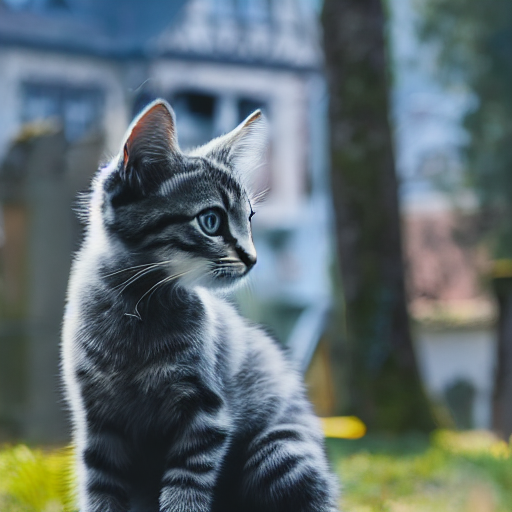

In [21]:
init_image, mask_image, example_image = img_examples[1]


image = ov_pipe_inpaint(image=init_image, mask_image=mask_image, reference_image=example_image, seed=2)
display(image["sample"][0])

Quantized pipeline:

  0%|          | 0/50 [00:00<?, ?it/s]

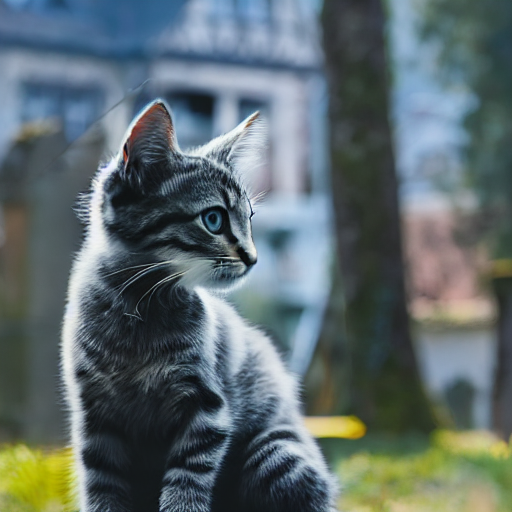

In [22]:
image = int8_ov_pipe_inpaint(image=init_image, mask_image=mask_image, reference_image=example_image, seed=2)
display(image["sample"][0])

### Compare UNet file size
[back to top ⬆️](#Table-of-contents:)

In [23]:
%%skip not $to_quantize.value

fp16_ir_model_size = UNET_OV_PATH_INPAINT.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = UNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 1024

print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 1678780.62 KB
INT8 model size: 840725.98 KB
Model compression rate: 1.997


## Interactive inference

[back to top ⬆️](#Table-of-contents:)

Choose a source image and a reference image, draw a mask in source image and push "Paint!"

In [ ]:
# Code adapated from https://huggingface.co/spaces/Fantasy-Studio/Paint-by-Example/blob/main/app.py

import os
import gradio as gr

def predict(input_dict, reference, seed, steps):
    """
        This function runs when the 'paint' button is pressed. It takes 3 input images. Takes generated image decoded by VAE decoder, unpad it to initila image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, convertes it from np.ndarray to PIL.Image format
        
        Parameters:
            input_dict (Dict):
                Contains two images in a dictionary
                    'image' is the image that will be painted on
                    'mask' is the black/white image specifying where to paint (white) and not to paint (black)
            image (PIL.Image.Image):
                Reference image that will be used by the model to know what to paint in the specified area
            seed (int):
                Used to initialize the random number generator state
            steps (int):
                The number of denoising steps to run during inference. Low = fast/low quality, High = slow/higher quality
        Returns:
            image (PIL.Image.Image):
                Postprocessed images
    """
    width, height = input_dict["image"].size

    # If the image is not 512x512 then resize
    if width < height:
        factor = width / 512.0
        width = 512
        height = int((height / factor) / 8.0) * 8
    else:
        factor = height / 512.0
        height = 512
        width = int((width / factor) / 8.0) * 8

    init_image = input_dict["image"].convert("RGB").resize((width,height))
    mask = input_dict["mask"].convert("RGB").resize((width,height))

    # If the image is not a 512x512 square then crop
    if width > height:
        buffer = (width - height) / 2
        input_image = init_image.crop((buffer, 0, width - buffer, 512))
        mask = mask.crop((buffer, 0, width - buffer, 512))
    elif width < height:
        buffer = (height - width) / 2
        input_image = init_image.crop((0, buffer, 512, height - buffer))
        mask = mask.crop((0, buffer, 512, height - buffer))
    else:
        input_image = init_image

    if not os.path.exists('output'):
        os.mkdir('output')
    input_image.save('output/init.png')
    mask.save('output/mask.png')
    reference.save('output/ref.png')

    mask = [mask]

    result = ov_pipe_inpaint(
        image=input_image,
        mask_image=mask,
        reference_image=reference,
        seed=seed,
        num_inference_steps=steps,
    )["sample"][0]

    out_dir = Path("output")
    out_dir.mkdir(exist_ok=True)
    result.save('output/result.png')

    return result


example = {}
ref_dir = 'data/reference'
image_dir = 'data/image'
ref_list = [os.path.join(ref_dir,file) for file in os.listdir(ref_dir) if file.endswith(".jpg")]
ref_list.sort()
image_list = [os.path.join(image_dir,file) for file in os.listdir(image_dir) if file.endswith(".png")]
image_list.sort()


image_blocks = gr.Blocks()
with image_blocks as demo:
    with gr.Group():
        with gr.Row():
            with gr.Column():
                image = gr.Image(source='upload', tool='sketch', elem_id="image_upload", type="pil", label="Source Image")
                reference = gr.Image(source='upload', elem_id="image_upload", type="pil", label="Reference Image")

            with gr.Column():
                image_out = gr.Image(label="Output", elem_id="output-img")
                steps = gr.Slider(label="Steps", value=15, minimum=2, maximum=75, step=1, interactive=True)

                seed = gr.Slider(0, 10000, label='Seed (0 = random)', value=0, step=1)

                with gr.Row(elem_id="prompt-container"):
                    btn = gr.Button("Paint!")
                       
        with gr.Row():
            with gr.Column():
                gr.Examples(image_list, inputs=[image],label="Examples - Source Image",examples_per_page=12)
            with gr.Column():
                gr.Examples(ref_list, inputs=[reference],label="Examples - Reference Image",examples_per_page=12)
        
        btn.click(fn=predict, inputs=[image, reference, seed, steps], outputs=[image_out])

# Launching the Gradio app
try:
    image_blocks.launch(debug=True, height=680)
except Exception:
    image_blocks.queue().launch(share=True, debug=True, height=680)
# if you are launching remotely, specify server_name and server_port
# image_blocks.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/